<a href="https://colab.research.google.com/github/tarangga/Machine-Learning/blob/main/Dicoding_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
 
df = pd.read_csv('/content/drive/My Drive/Colab Data/Dicoding/household_power_consumption.txt', sep=';')
df = df[['Global_active_power', 'Date', 'Time']]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:

def func(x):
  if(x != '?'):
    return float(x)
  else:
    return np.NaN

df['Global_active_power'] = df['Global_active_power'].apply(func)
print(df.isnull().sum())
mean = df['Global_active_power'].mean()
df['Global_active_power'] = df['Global_active_power'].fillna(mean)
print(df.isnull().sum())

Global_active_power    25979
Date                       0
Time                       0
dtype: int64
Global_active_power    0
Date                   0
Time                   0
dtype: int64


In [ ]:
data = df[['Global_active_power']]
data['Timestamp'] = df['Date'] + ' ' + df['Time']
data['Global_active_power'] = data[data['Global_active_power'] != '?']['Global_active_power'].astype('float32')
data.dropna(inplace=True)
data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

,Global_active_power,Timestamp
0,4.216,16/12/2006 17:24:00
1,5.360,16/12/2006 17:25:00
2,5.374,16/12/2006 17:26:00
3,5.388,16/12/2006 17:27:00
4,3.666,16/12/2006 17:28:00
...,...,...
2075254,0.946,26/11/2010 20:58:00
2075255,0.944,26/11/2010 20:59:00
2075256,0.938,26/11/2010 21:00:00
2075257,0.934,26/11/2010 21:01:00


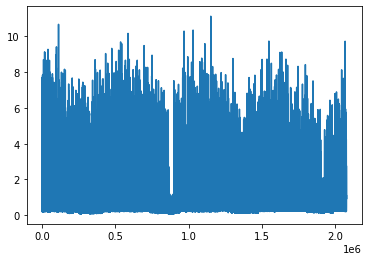

In [ ]:
import matplotlib.pyplot as plt

plt.plot(data['Global_active_power'])
plt.show()

In [ ]:
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['Global_active_power'].values, data['Timestamp'], test_size=0.2)
train_set = windowed_dataset(X_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(X_test, window_size=60, batch_size=100, shuffle_buffer=1000)

In [ ]:

callback = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=7)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu'),
  tf.keras.layers.MaxPooling1D(pool_size=2),
  tf.keras.layers.Conv1D(filters=32, kernel_size=2, activation='relu'),
  tf.keras.layers.MaxPooling1D(pool_size=2),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.5)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=50, callbacks=[callback], batch_size=32,
                    validation_data=test_set, steps_per_epoch=512)

Epoch 1/50
512/512 [==============================] - 54s 106ms/step - loss: 0.6147 - mae: 0.9309 - val_loss: 0.5412 - val_mae: 0.8248
Epoch 2/50
512/512 [==============================] - 54s 106ms/step - loss: 0.4924 - mae: 0.7868 - val_loss: 0.4579 - val_mae: 0.7746
Epoch 3/50
512/512 [==============================] - 54s 106ms/step - loss: 0.4318 - mae: 0.7701 - val_loss: 0.4140 - val_mae: 0.7708
Epoch 4/50
512/512 [==============================] - 55s 106ms/step - loss: 0.4062 - mae: 0.7757 - val_loss: 0.3971 - val_mae: 0.7749
Epoch 5/50
512/512 [==============================] - 55s 108ms/step - loss: 0.3963 - mae: 0.7805 - val_loss: 0.3918 - val_mae: 0.7791
Epoch 6/50
512/512 [==============================] - 54s 105ms/step - loss: 0.3894 - mae: 0.7787 - val_loss: 0.3905 - val_mae: 0.7818
Epoch 7/50
512/512 [==============================] - 54s 105ms/step - loss: 0.3906 - mae: 0.7830 - val_loss: 0.3901 - val_mae: 0.7832
Epoch 8/50
512/512 [==============================] - 5

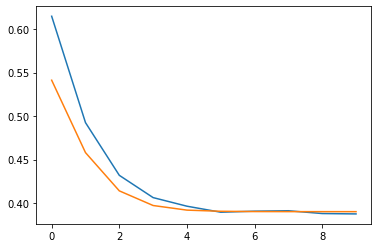

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

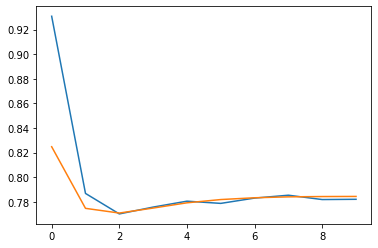

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.show()